# **Load Libraries**

In [0]:
import numpy as np
import string
import os
from datetime import datetime as dt

import cv2

import tensorflow as tf
import matplotlib.pyplot as plt

bold = '\033[1m'
end = '\033[0m'

# **Functions**

In [0]:
def read_data(file_list):
  '''
  read data from tfrecords file
  '''
  file_queue=tf.train.string_input_producer(file_list)
  feature = {'images': tf.FixedLenFeature([], tf.string),
             'labels': tf.FixedLenFeature([], tf.string)}    
  reader = tf.TFRecordReader()  
  _,record=reader.read(file_queue)
  features = tf.parse_single_example(record, features=feature)
  img = tf.decode_raw(features['images'], tf.uint8)
  label = tf.decode_raw(features['labels'], tf.uint8)	
  return img,label



def minibatch(folder_path, filename, file_count, 
              image_size, max_char, class_count, 
              batch_size,):
  '''
  generate minibatch
  '''
  file_list = [os.path.join(folder_path, filename + '%d.tfrecords' % i) for i in range(1, file_count+1)]  
  img, label = read_data(file_list)
  img = tf.cast(tf.reshape(img,img_size), dtype = tf.float32)
  label = tf.reshape(label, [1, max_char])
  label = tf.one_hot(label,class_count,axis=1)
  label = tf.reshape(label,tf.shape(label)[1:])
  img_batch,label_batch= tf.train.shuffle_batch([img, label],batch_size,capacity,min_after_dequeue,num_threads=num_of_threads)
  return img_batch, tf.cast(label_batch, dtype = tf.int64)



def variable(name,shape,initializer,weight_decay = None):
  '''
  create parameter tensor
  '''
  var = tf.get_variable(name, shape, initializer = initializer)
  if weight_decay is not None:
    weight_loss=tf.multiply(tf.nn.l2_loss(var),weight_decay,name="weight_loss")
    tf.add_to_collection('losses', weight_loss)
  return var



def conv_block(block_num,
               input_data,
               weights, 
               weight_initializer=tf.contrib.layers.xavier_initializer(),
               bias_initializer=tf.constant_initializer(0.0),
               conv_op=[1,1,1,1],
               conv_padding='SAME',
               weight_decay=None,
               lrn=True,
               dropout=1.0, 
               activation=True):
  '''
  convolutional block
  '''
  with tf.variable_scope('conv'+ str(block_num), reuse = tf.AUTO_REUSE) as scope:
    input_data = tf.nn.dropout(input_data, dropout)
    kernel = variable('weights', weights, initializer = weight_initializer, weight_decay = weight_decay)
    biases = variable('biases', weights[3], initializer=bias_initializer, weight_decay=None)
    conv = tf.nn.conv2d(input_data, kernel, conv_op, padding=conv_padding)
    pre_activation = tf.nn.bias_add(conv, biases)
    if lrn==True:
      pre_activation = tf.nn.lrn(pre_activation, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,name='norm')
    if activation:
      conv_out = tf.nn.relu(pre_activation, name=scope.name)
      return conv_out
    else:
      return pre_activation



def dense_block(block_num,
                input_data,
                neurons,
                weight_initializer=tf.contrib.layers.xavier_initializer(),
                bias_initializer=tf.constant_initializer(0.0),
                weight_decay=None,
                activation=True, 
                dropout=1.0):
  '''
  Fully connected block
  '''
  with tf.variable_scope('dense'+ str(block_num), reuse = tf.AUTO_REUSE) as scope:
    input_data = tf.nn.dropout(input_data, dropout)
    weights = variable('weights', [input_data.shape[1], neurons], initializer=weight_initializer, weight_decay = weight_decay)
    biases = variable('biases', [1,neurons], initializer = bias_initializer, weight_decay = None)
    dense = tf.matmul(input_data,weights)+biases
    if activation:
      dense=tf.nn.relu(dense, name=scope.name)
    return dense
  
  
  
def multi_loss(logits, labels, batch_size, max_char):
  '''
  cross entopy loss for multi class
  '''
  loss = 0
  for i in range(max_char):
    loss += tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits\
            (logits=logits[:,i,:],labels=labels[:,:,i]), \
                           name='cross_entropy_loss_mean')
  loss /= max_char
  tf.add_to_collection('losses', loss)
  total_loss=tf.add_n(tf.get_collection('losses'), name='total_loss')
  tf.add_to_collection('losses', total_loss)
  return total_loss


  
def parameter_update(loss, learning_rate):
  '''
  optimization and parameter update using adam optimizer
  '''
  optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
  for var in tf.trainable_variables():
    tf.summary.histogram(var.op.name, var)
  return optimizer



def accuracy_calc(output, label_batch):
  '''
  calculate accuracy
  '''
  correct_prediction = tf.equal(tf.cast(tf.argmax(output, 2),dtype=tf.int32),tf.cast(tf.argmax(label_batch, 1),dtype=tf.int32))
  accuracy=tf.reduce_mean(tf.cast(correct_prediction,"float"))
  return accuracy



#evaluation
def eval(batch_size=1000):
	steps=((test_data_count))//batch_size
	accu=0
	x_test, y_test = minibatch(folder_path, test_filename, file_count, img_size, max_char, class_count,batch_size)
	logit_test = inference(x_test, class_count)
	accuracy_test = accuracy_calc(logit_test, y_test)
  
	init=tf.global_variables_initializer()
	saver=tf.train.Saver()
	with tf.Session() as sess:
		sess.run(init)
		coord = tf.train.Coordinator()
		threads = tf.train.start_queue_runners(coord=coord)
		saver.restore(sess,checkpoint_restore)
		for s in range(steps):
			acc=sess.run(accuracy_test)
			accu+=acc/steps
		print("test set accuracy: ",acc)

		coord.request_stop()
		coord.join(threads)

		return None
  
  
def decoding(encoded_data, type = 'logit'):
  if(type == 'logit'):
    prediction = np.argmax(encoded_data, 2)
  elif(type == 'label'):
    prediction = np.argmax(encoded_data, 1)
  decoded_prediction = []
  for dp in prediction:
    predicted_text = ''
    for p in dp:
      predicted_text += all_chr[p]
    decoded_prediction.append(predicted_text)
  return decoded_prediction



def eval_vizualization(X):
  decoded_text = []
  logit = inference(X, class_count)
  init=tf.global_variables_initializer()
  saver=tf.train.Saver()
  
  with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess,checkpoint_restore)
    text = sess.run(logit)
    decoded_text = decoding(text, type = 'logit')
  for i in range(X.shape[0]):
    x = np.reshape(X[i, :,:,:], img_size[0:2])
    plt.imshow(x, cmap = 'gray')
    plt.show()
    print("text: ", decoded_text[i], '<---')

# **Model**

In [0]:
def inference(image_batch, class_count,
              dropout=[1,1,1,1],
              wd=None):
  '''
  Forward propagation
  '''

  i = 0
  weights=[[3,3,1,class_count//4],
           [3,3,class_count//4,class_count//2],
           [3,3,class_count//2,class_count],
           [3,3,class_count,class_count]]
  conv_op=[[1,1,1,1],[1,1,1,1],[1,1,1,1], [1,1,1,1]]
  
  conv1 = conv_block(1,image_batch,weights[i], conv_op = conv_op[i], conv_padding='SAME', dropout=dropout[i],weight_decay=wd)
  i=i+1
  pool1=tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1,2,2,1],padding='VALID', name='pool1') #16x128
  
  conv2 = conv_block(2,pool1,weights[i], conv_op = conv_op[i], conv_padding='SAME', dropout=dropout[i],weight_decay=wd)
  i=i+1
  pool2=tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1,2,2,1],padding='VALID', name='pool2') #8x64
  
  conv3 = conv_block(3,pool2,weights[i], conv_op = conv_op[i], conv_padding='SAME', dropout=dropout[i],weight_decay=wd)
  i=i+1
  pool3=tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1,2,2,1],padding='VALID', name='pool3') #4x32
  
  conv4 = conv_block(4,pool3,weights[i], conv_op = conv_op[i], conv_padding='SAME', dropout=dropout[i],weight_decay=wd)
  pool4=tf.nn.max_pool(conv4, ksize=[1, 4, 2, 1], strides=[1,1,2,1],padding='VALID', name='pool4') #1x16
  
  flat=tf.reshape(pool4, [tf.shape(image_batch)[0],max_char, class_count], name='flat')
		
  return flat

# **Train**

In [0]:
def train(folder_path, train_filename, test_filename, 
          data_per_train_file, test_data_count, file_count,
          weights, dropout, wd,
          img_size, max_char, class_count, 
          batch_size = 32, learning_rate=0.01, epochs=5, 
          restore=False, var_lr = [None,None]):
  
	train_step = train_data_count//batch_size
	test_step = test_data_count//batch_size
  
  #build graph
	with tf.Graph().as_default():
		x_train, y_train = minibatch(folder_path, train_filename, file_count, img_size, max_char, class_count,batch_size)     
		logit_train = inference(x_train, class_count, dropout = dropout, wd = wd)
		cost = multi_loss(logit_train, y_train, batch_size, max_char)
		update=parameter_update(cost,learning_rate)	
		accuracy_train = accuracy_calc(logit_train, y_train)
    
		x_test, y_test = minibatch(folder_path, test_filename, file_count, img_size, max_char, class_count,batch_size)
		logit_test = inference(x_test, class_count)
		accuracy_test = accuracy_calc(logit_test, y_test)
    
		saver = tf.train.Saver()
    
    #start session
		with tf.Session() as sess:
      #initialize the variables
			sess.run(tf.global_variables_initializer())
			sess.run(tf.local_variables_initializer())
			coord = tf.train.Coordinator()
			threads = tf.train.start_queue_runners(coord=coord) 
      
      #restore the variables
			if restore == True:
				loader = tf.train.import_meta_graph(checkpoint_restore +'.meta')
				loader.restore(sess, checkpoint_restore)
        
			#train for given number of epochs
			for e in range(epochs): 
				print(bold + "\nepoch:" + end, e)
				train_epoch_cost = 0
				train_epoch_acc = 0
				test_epoch_acc = 0
        
        #train for given number of steps in one epoch
				for s in range(train_step):
					_,train_batch_cost = sess.run([update, cost])	          
					if s % (train_step//20) == 0 and s != 0:
						print('~', end = '')
					elif(s == (train_step) - 1):
						print('')            
					train_epoch_cost += train_batch_cost/(train_step)	          
				print(bold + "epoch_cost: " + end,train_epoch_cost)
        
        #calculate accuracy of training set
				for i in range(train_step//5):
					train_epoch_acc = sess.run(accuracy_train)
					train_epoch_acc += train_epoch_acc/(train_step)        
				print(bold + "train epoch accuracy: " + end,train_epoch_acc, "\n")
        
        #calculate accuracy of test set
				for i in range(test_step):
					test_epoch_acc = sess.run(accuracy_test)
					test_epoch_acc += test_epoch_acc/test_step    
				print(bold + "test epoch accuracy: " + end, test_epoch_acc, "\n")
        
        #afer every 20 epoch decrease learning rate by factor of 10
				if var_lr[0] != None:
					if e%var_lr[0] == 0:
						learning_rate = learning_rate/var_lr[1]
      
      #save all the variables
			save_path = saver.save(sess, checkpoint_save)	
			coord.request_stop()
			coord.join(threads)
			
	return None

In [0]:
folder_path = "drive/share/OCR/tfrecords/"
file_count = 2
train_data_count = 8192 * file_count
test_data_count = 2048 * file_count
img_size = [32,256,1]
class_count = 63
max_char = 16
keyword = '3to8'
train_filename = 'train_' + keyword + '_'
test_filename = 'test_' + keyword + '_'
checkpoint_restore = "drive/share/OCR/checkpoints/checkpoint_3to8.ckpt"
checkpoint_save = "drive/share/OCR/checkpoints/checkpoint_3to8.ckpt"

dropout = [1, 1, 1, 1]
wd = 0.000
lr = 0.01
batch_size = 32
epochs = 5

num_of_threads=16
min_after_dequeue=5000
capacity=min_after_dequeue+(num_of_threads+1)*batch_size

In [20]:
train(folder_path, train_filename, test_filename, 
      train_data_count, test_data_count, file_count,
      class_count, dropout, wd,
      img_size, max_char, class_count, 
      batch_size=batch_size, learning_rate=lr, epochs=epochs, 
      restore=True, var_lr=[None,None])

INFO:tensorflow:Restoring parameters from drive/share/OCR/checkpoints/checkpoint_3to8.ckpt

epoch: 0
~~~~~~~~~~~~~~~~~~~~
epoch_cost:  0.5589512566803023
train epoch accuracy:  0.9119338989257812 

test epoch accuracy:  0.8345947265625 


epoch: 1
~~~~~~~~~~~~~~~~~~~~
epoch_cost:  0.5408127859700471
train epoch accuracy:  0.8982353210449219 

test epoch accuracy:  0.87396240234375 


epoch: 2
~~~~~~~~~~~~~~~~~~~~
epoch_cost:  0.5190971170086414
train epoch accuracy:  0.876708984375 

test epoch accuracy:  0.9113616943359375 


epoch: 3
~~~~~~~~~~~~~~~~~~~~
epoch_cost:  0.5113609346444719
train epoch accuracy:  0.8943214416503906 

test epoch accuracy:  0.90545654296875 


epoch: 4
~~~~~~~~~~~~~~~~~~~~
epoch_cost:  0.48407231707824394
train epoch accuracy:  0.8864936828613281 

test epoch accuracy:  0.9389190673828125 



# **Evaluate**

In [0]:
eval()

INFO:tensorflow:Restoring parameters from drive/share/OCR/checkpoints/checkpoint_3to8.ckpt


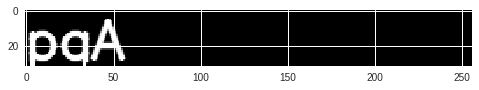

text:  pgA              <---


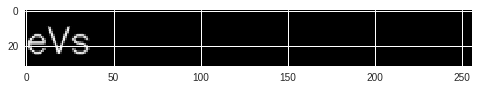

text:  eVs              <---


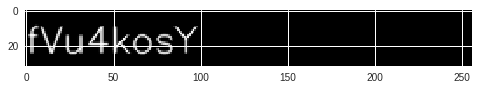

text:  fV44osY          <---


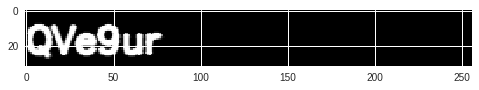

text:  QVeuur           <---


In [13]:
all_chr = list(string.ascii_letters) + list(string.digits) + list(' ')
x_check, y_check=minibatch(folder_path, train_filename, file_count, img_size, max_char, class_count,batch_size) 
saver = tf.train.Saver()

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  sess.run(tf.local_variables_initializer())
  coord = tf.train.Coordinator()
  threads = tf.train.start_queue_runners(coord=coord) 
  
  x_c = sess.run(x_check)  
  eval_vizualization(x_c[1:5])
  
  coord.request_stop()
  coord.join(threads)